# Colab Filtering Demo

### Import dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Run this to be able to import 'Modules' on the notebook
import sys, os
sys.path.insert(0, os.path.abspath(".."))

### Data analysis

##### Overview

In [2]:
ratings = pd.read_csv("../data/steam-90k/steam-90k.csv")
n_ratings = len(ratings)
n_games = ratings["app_id"].nunique()
n_users = ratings["user_id"].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique games: {n_games}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per game: {round(n_ratings/n_games, 2)}")
print(f"Mean global rating: {round(ratings["rating"].mean(),2)}.")

Number of ratings: 92726
Number of unique games: 5360
Number of unique users: 5840
Average number of ratings per user: 15.88
Average number of ratings per game: 17.3
Mean global rating: 0.76.


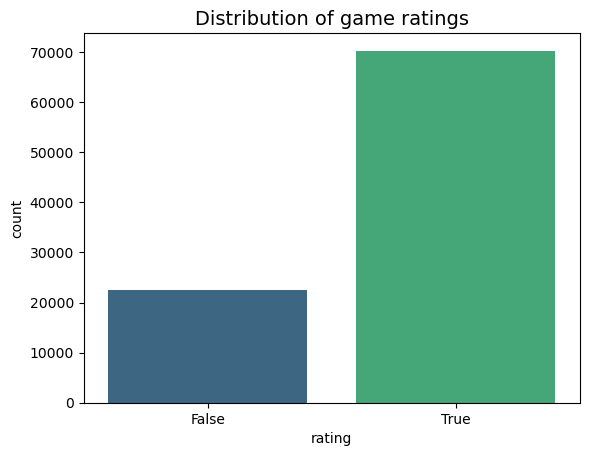

In [3]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of game ratings", fontsize=14)
plt.show()

##### Most rated games

In [9]:
game_stats = ratings.groupby("title")["rating"].agg(["count", "mean"])
game_stats.sort_values(by=["count", "mean"], ascending=False).head()

,count,mean
title,,
Dragon's Dogma 2,89,0.629213
100 March Cats,66,0.984848
100 Robo Cats,66,0.833333
100 Capitalist Cats,65,0.969231
100 Dino Cats,57,1.000000


### Preprocess data

##### Import from csv

In [5]:
from Modules.CF import PreProcessing

# X: Array of user-item pairs
# y: Corresponding ratings for each user-item pair in
# M: Mapping consists of 5 dictionaries:
#    user_to_index, index_to_user, item_to_index, index_to_item, item_to_name
# ui_shape: tuple of (num_users, num_items)

X, y, M, ui_shape = PreProcessing.data_from_csv("../data/steam-90k/steam-90k.csv")
print("User-Item:", ui_shape)

User-Item: (5840, 5360)


##### Option for spliting data

In [6]:
X_train, y_train, X_test, y_test = PreProcessing.split(X, y, 0.8, shuffle=True)

### Load data into model

In [7]:
from Modules.CF import Similarity, CF

sim_func = Similarity.inverse_euclidean_squared
cf_model = CF(sim_func, mode="uucf", n_neighbors=10)
cf_model.fit(X_train, y_train, ui_shape)

### Get prediction

In [8]:
y_pred = cf_model.predict(X_test)
print("True:", y_test)
print("Pred:", y_pred)

True: [1. 0. 1. ... 1. 1. 1.]
Pred: [0.94909808 0.13627691 0.92677097 ... 0.73365109 0.83757803 1.02214908]


### Evaluation

In [9]:
from sklearn.metrics import r2_score, mean_squared_error
print("R2  :", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

R2  : 0.2966979901307313
RMSE: 0.3588771735468142


### Get recommendations for an user

In [10]:
cf_model.fit(X, y, ui_shape)

In [11]:
user_idx = np.random.randint(cf_model.num_users)
user = M.index_to_user[user_idx]
print(f"Picked user: {user}")

Picked user: 76561198008049239


In [12]:
games, ratings = cf_model.get_recommendation(user_idx, 10)
app_ids = [M.index_to_item[i] for i in games]
titles = [M.item_to_name[i] for i in app_ids]
rec = pd.DataFrame({
    "app_id": app_ids,
    "titles": titles,
    "rating": ratings
})
rec

,app_id,titles,rating
0,372350,Tumbleweed Express,1.181875
1,671550,Brickochet,1.162284
2,1416460,Horror Globes,1.160728
3,1185470,Deathbloom: Chapter 2,1.154234
4,726020,Mission Ammunition,1.150266
5,639560,Spacescape,1.145438
6,558450,Fibrillation HD,1.134927
7,337450,Dream Tale,1.133859
8,1301480,Bishoujo Battle Mahjong Solitaire,1.122258
9,511350,Mr. Massagy,1.121493
